In [53]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [41]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

In [1]:
targets = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

NameError: name 'pd' is not defined

In [2]:
targets.head()

NameError: name 'targets' is not defined

In [44]:
stations.head()

,code,name,lat,lon,height,city,country
0,ES1480A,Barcelona (Gràcia-Sant Gervasi),41.3987,2.15339,57,Barcelona,España
1,ES1856A,Barcelona (Vall d'Hebron),41.4261,2.14799,136,Barcelona,España
2,ES1679A,Ciutadella,41.3864,2.18742,7,Barcelona,España
3,ES1438A,Barcelona (Eixample),41.3853,2.15382,26,Barcelona,España
4,ES1396A,Barcelona,41.3788,2.13310,35,Barcelona,España


In [79]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        data['year'] = year
        data['station'] = station
        observations.append(data)
        
observations = pd.concat(observations)
observations.sample(5)

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,AveragingTime,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification,year,station
0,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1992A,ES1992A,SP_08019057_8_8,SPP_08019057_8_8.1,SAM_08019057_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,12,µg/m3,2013-02-13 01:00:00,2013-02-13 02:00:00,1,1,2013,ES1992A
1,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1992A,ES1992A,SP_08019057_8_8,SPP_08019057_8_8.1,SAM_08019057_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,13,µg/m3,2013-02-13 02:00:00,2013-02-13 03:00:00,1,1,2013,ES1992A
2,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1992A,ES1992A,SP_08019057_8_8,SPP_08019057_8_8.1,SAM_08019057_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,12,µg/m3,2013-02-13 03:00:00,2013-02-13 04:00:00,1,1,2013,ES1992A
3,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1992A,ES1992A,SP_08019057_8_8,SPP_08019057_8_8.1,SAM_08019057_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,12,µg/m3,2013-02-13 04:00:00,2013-02-13 05:00:00,1,1,2013,ES1992A
4,in/ES_8_2013-2015_timeseries.csv:ES,ES.BDCA.AQD,NET_ES209A,STA_ES1992A,ES1992A,SP_08019057_8_8,SPP_08019057_8_8.1,SAM_08019057_8_8,NO2,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,20,µg/m3,2013-02-13 05:00:00,2013-02-13 06:00:00,1,1,2013,ES1992A


In [90]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models)
models.sample(5)

,lon,lat,day,hour,AirPollutant,Concentration,year,station
4,2.14799,41.4261,2014-09-19,04:00:00,NO2,24.42280,2014,ES1856A
6,2.18742,41.3864,2013-05-15,06:00:00,NO2,15.74780,2013,ES1679A
27,2.11515,41.3875,2015-11-02,03:00:00,NO2,5.91385,2015,ES1992A
40,2.20452,41.4039,2013-01-02,16:00:00,NO2,14.36930,2013,ES0691A
21,2.18742,41.3864,2015-02-09,21:00:00,NO2,93.17560,2015,ES1679A


In [94]:
observations.groupby(['station', 'AirPollutant']).agg({
    'Concentration': ['mean', 'std', 'var']
})

Concentration                       
                              mean        std         var
station AirPollutant                                     
ES0691A NO2              41.041319  23.278777  541.901469
ES1396A NO2              33.747620  21.847828  477.327583
ES1438A NO2              55.131554  25.452065  647.807589
ES1480A NO2              53.613499  27.370526  749.145685
ES1679A NO2              37.823535  23.731780  563.197397
ES1856A NO2              29.057570  22.203759  493.006923
ES1992A NO2              32.639648  24.233027  587.239574

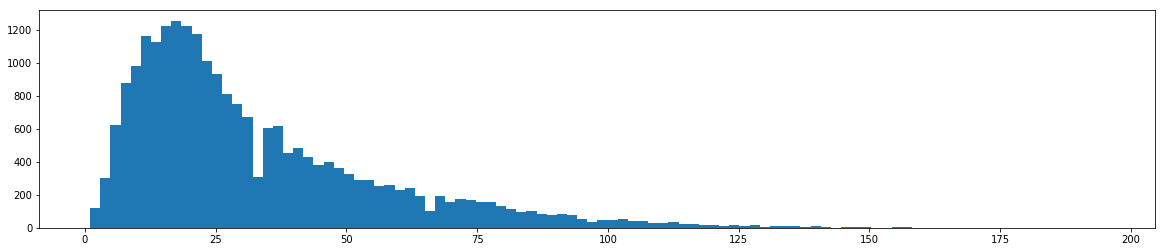

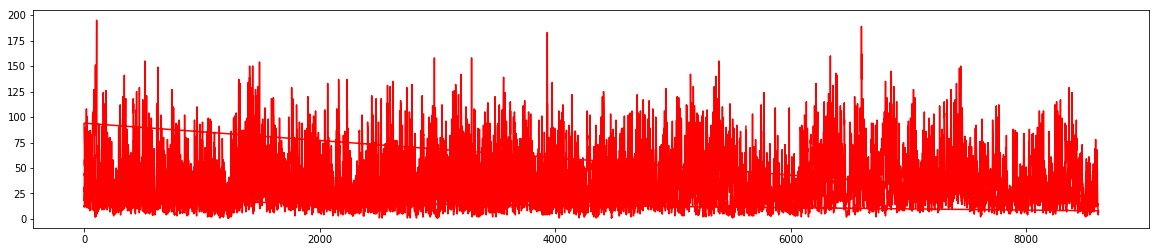

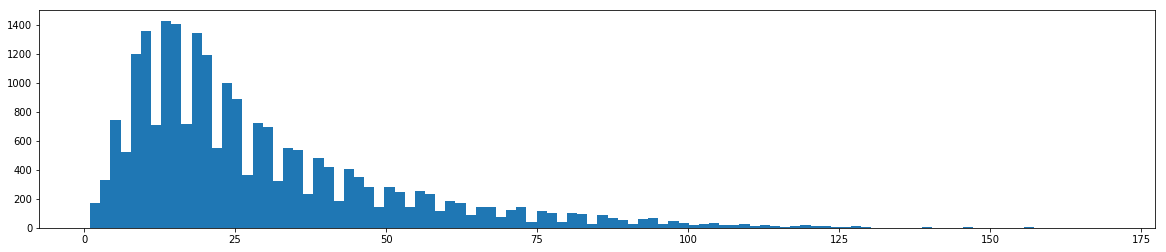

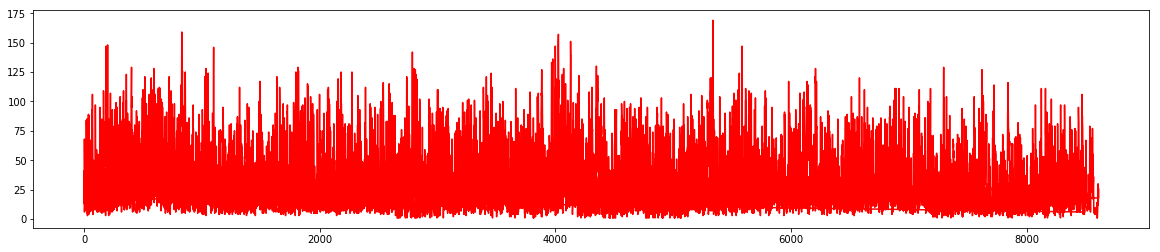

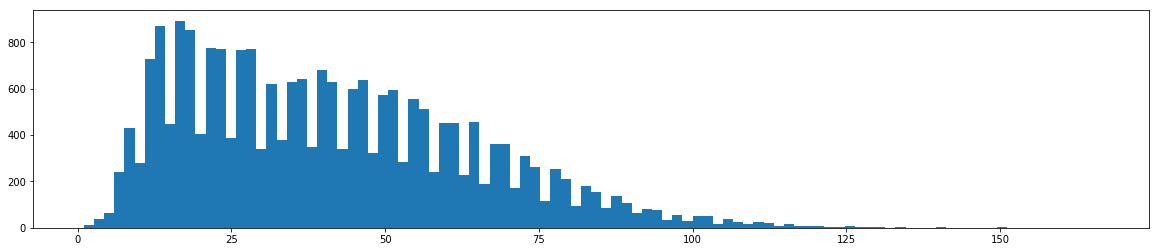

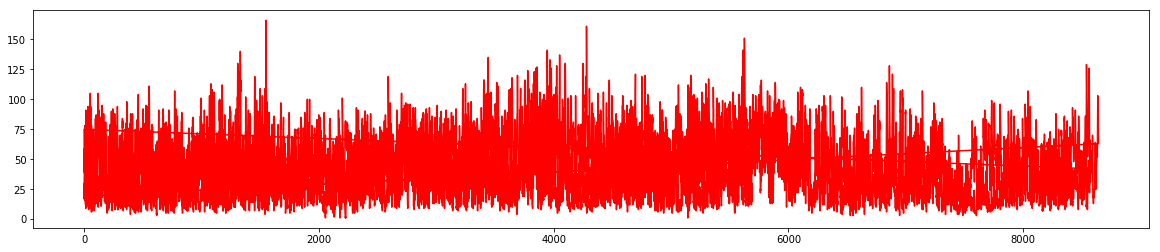

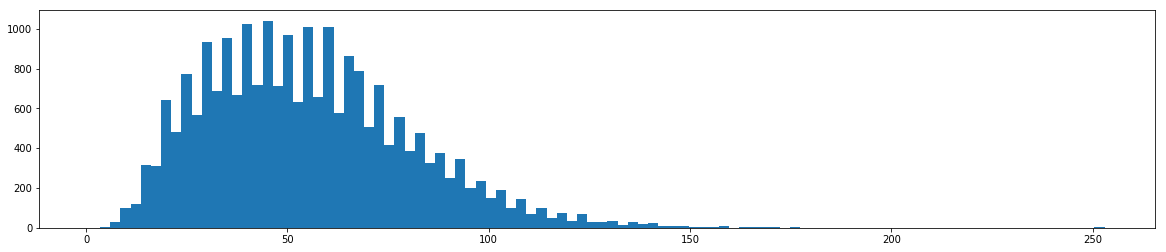

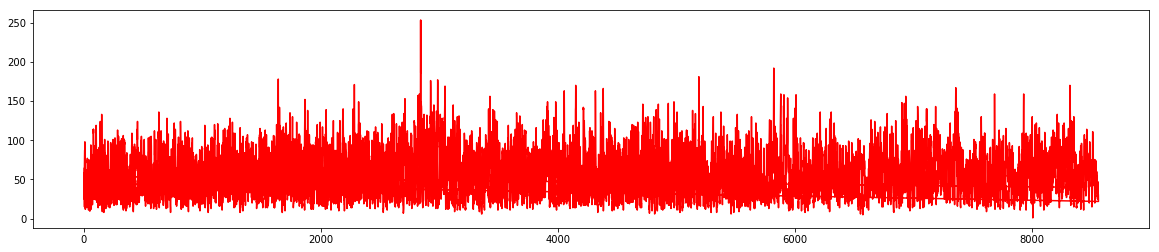

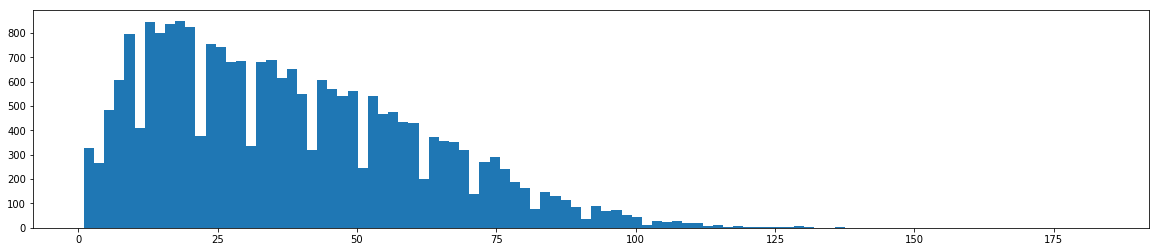

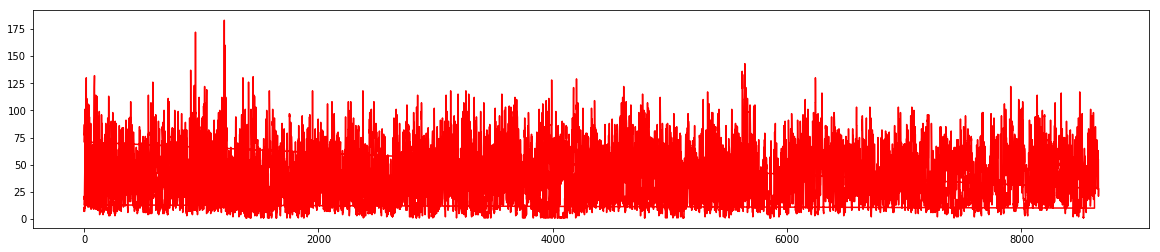

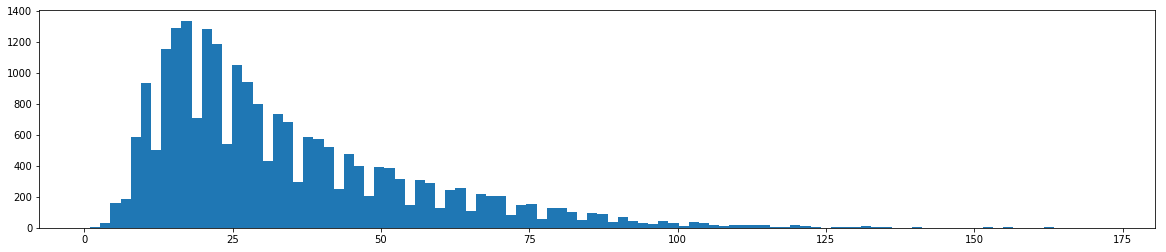

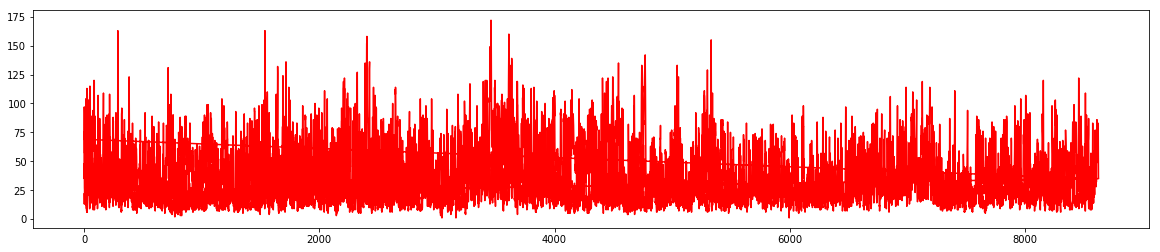

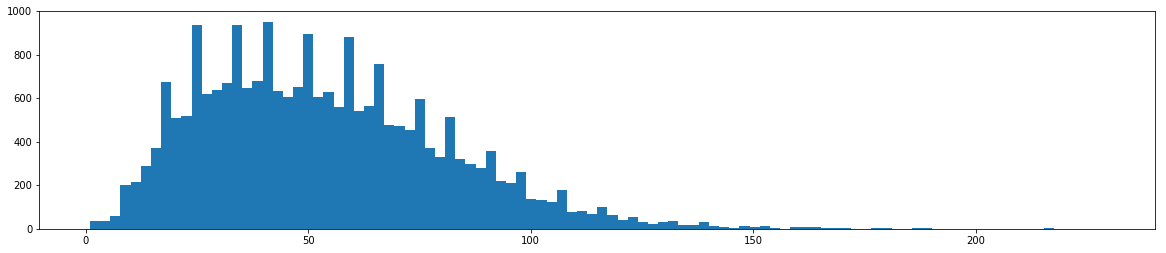

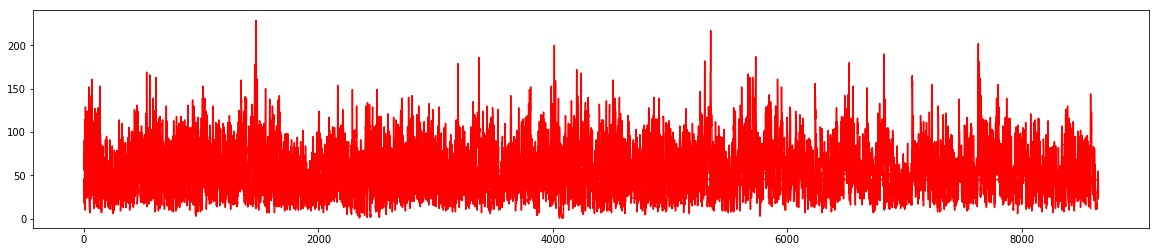

In [116]:
for s in observations['station'].unique():
    plt.figure(figsize=(20, 4))
    plt.hist(observations[observations['station'] == s]['Concentration'], bins=100)
    plt.figure(figsize=(20, 4))
    plt.plot(observations[observations['station'] == s]['Concentration'], 'r-')